# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.899992,True,4.169054
1,1.833781,True,6.639914
2,0.466133,False,-0.939372
3,1.699762,True,5.284648
4,-0.052451,False,-0.767903
...,...,...,...
995,1.468126,True,6.540777
996,0.879400,True,5.470851
997,0.467582,False,1.008676
998,1.495810,True,8.113949


<AxesSubplot: xlabel='v0'>

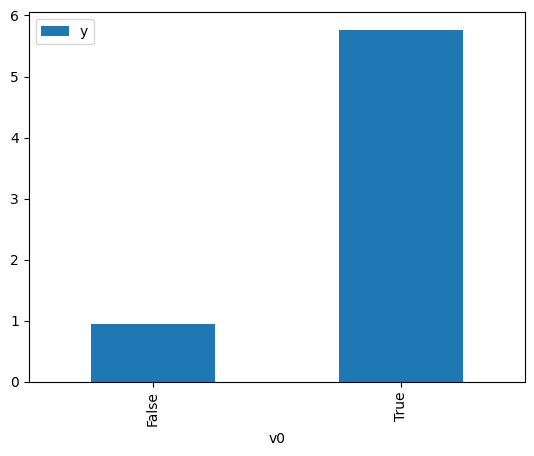

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

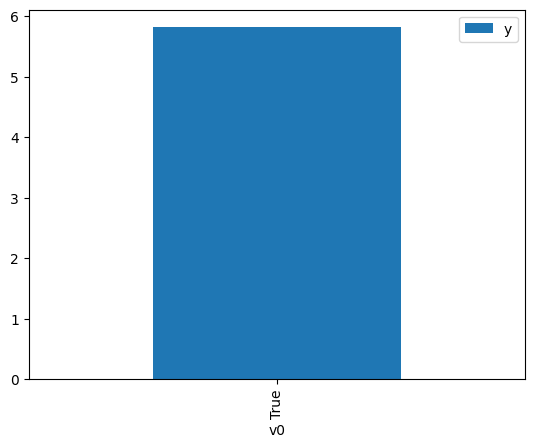

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.732081,False,2.544611,0.103271,9.683283
1,0.697862,False,1.519453,0.310665,3.218906
2,-0.326625,False,-0.709300,0.635187,1.574340
3,0.513354,False,1.447516,0.365029,2.739509
4,2.530053,False,2.854694,0.038638,25.881357
...,...,...,...,...,...
995,0.966491,False,1.587474,0.240233,4.162620
996,1.568442,False,3.974575,0.125043,7.997270
997,1.075526,False,1.056835,0.214966,4.651888
998,-0.744765,False,-1.478571,0.751413,1.330826


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.458283,True,8.219874,0.858172,1.165267
1,-0.656625,True,4.742576,0.270935,3.690925
2,0.325519,True,5.394875,0.575860,1.736532
3,-0.802024,True,5.624898,0.234747,4.259913
4,-0.464880,True,4.897026,0.323677,3.089503
...,...,...,...,...,...
995,1.929153,True,7.142161,0.918444,1.088798
996,2.512914,True,7.988423,0.960514,1.041110
997,1.249617,True,6.242082,0.821261,1.217640
998,1.725489,True,7.484072,0.895921,1.116170


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.960
Method:                 Least Squares   F-statistic:                          1.208e+04
Date:                Mon, 05 Jun 2023   Prob (F-statistic):                        0.00
Time:                        15:12:33   Log-Likelihood:                         -1453.9
No. Observations:                1000   AIC:                                      2912.
Df Residuals:                     998   BIC:                                      2922.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0239      0.037     27.690      0.000       0.951       1.096
x2             4.9710      0.058     85.406      0.000       4.857       5.085
==============================================================================
Omnibus:                        3.888   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                3.942
Skew:                           0.151   Prob(JB):                        0.139
Kurtosis:                       2.938   Cond. No.                         2.85
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""